인물사진을 만들어보자

## <폴더 생성>

In [1]:
# mkdir -p ~/aiffel/human_segmentation/models
# mkdir -p ~/aiffel/human_segmentation/images

## <이미지 준비>
이미지는 사람, 강아지, 전투기, 배경을 준비한다.

## <라이브러리 import하기>

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('완료')

완료


urllib는 웹에서 데이터를 다운로드할 때 사용한다.

cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요하다.

pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리이다.

(966, 773, 3)


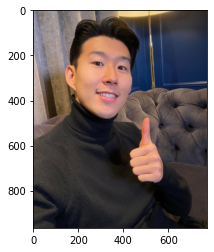

In [3]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/son4.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

준비한 이미지를 읽는다.

시작하기 전에 세그멘테이션(Segmentation)에 대해 알아 보겠다.

## 세그멘테이션(Segmentation)이란?

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation)이라고 한다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다. 이때 공통 특징은 물리적 의미가 없을 수도 있다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이다. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다.

## 시맨틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 한다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하면 된다. 지금 다룰 세그멘테이션 방법이기도 하다.

## 인스턴스 세그멘테이션(Instance segmentation)이란?

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법이다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 된다. 더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 한다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표이다.

딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?

## 워터쉐드 세그멘테이션(watershed segmentation)

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것이다. 그럼 경계는 어떻게 나눌 수 있을까?

이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가진다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있다. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 된다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 된다.

자세한 내용은 opencv-python tutorial을 참고하면 된다.

본격적으로 세그멘테이션을 다루어 보겠다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용해 볼 것이다. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있다.

DeepLab에 대한 자세한 설명은 [여기][1]를 참고하면 된다.

[1]:https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f9793258bb0>)

DeepLab 모델을 준비한다. 아까 준비한 PixelLib를 이용하면 편하게 사용할 수 있다. 먼저 PixelLib에서 제공해 주는 모델을 다운로드한다.

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성한다.

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

모델에 이미지를 입력한다.

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있다. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미이다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요하다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

PASCAL VOC 데이터의 라벨 종류는 위와 같다. background를 제외하면 20개의 클래스가 있다. 따라서 20 의 의미는 tv 가 된다! 0부터 시작하기 때문이다.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶다. 이제 사람만 어떻게 추출할 수 있을지 알아보자.

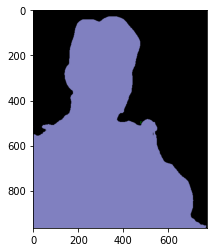

In [8]:
plt.imshow(output)
plt.show()

모델에서 나온 출력값을 확인해본다.

In [9]:
segvalues

{'class_ids': array([ 0, 15, 18]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
sofa


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다. segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다! 여기서는 배경, 사람, 소파가 담겨있는 것을 확인할 수 있다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같다.

In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 한다. 그럼 사람을 나타내는 15번째 색상은 무엇일까?

In [12]:
colormap[15]

array([192, 128, 128])

사람은 위와 같은 색상을 사용했다. 사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]를 이용하여 찾아낼 수 있다.

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. colormap은 RGB 순서이다.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 한다.

In [13]:
seg_color = (128,128,192)

(966, 773)


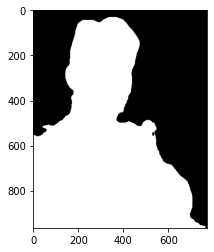

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

seg_color로만 이루어진 마스크를 만들어 보았다. 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌다. 이제 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.

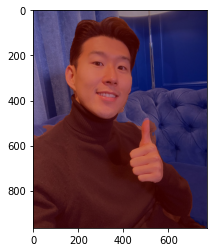

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같다. 결과는 위와 같다.

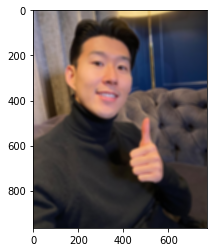

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만든다. 이때 blur() 함수를 이용한다.

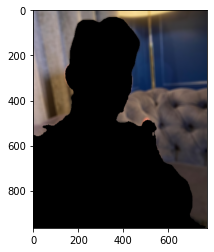

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠다.

bitwise_not 함수를 이용하면 이미지가 반전된다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 된다

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다. 결국 사람이 사라지게 된다.

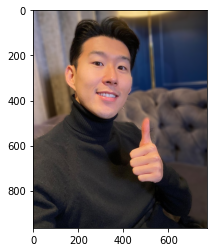

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경 영상과 사람 영상을 합쳐보았다. 보시다시피 사람에 초점이 맞춰진 결과가 나왔다. 잘했다고 손흥민이 엄지를 치켜 세웠다.

※ 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했다.

## 사진에서 문제점 찾기

문제점은 크게 없다. 오히려 쇼파색깔과 옷색깔이 비슷하면서도 어두운 색깔임에도 불구하고 잘 구별해냈다.

사람이 아닌 강아지에 대한 아웃포커싱 사진도 만들어 볼 수 있다.

(364, 550, 3)


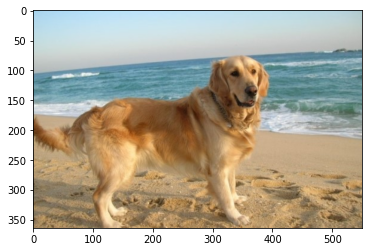

In [19]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog2.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

준비한 이미지를 읽는다.

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path)

모델에 이미지를 입력한다.

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있다. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미이다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요하다.

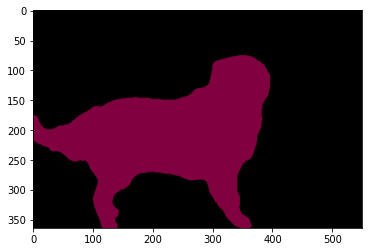

In [21]:
plt.imshow(output)
plt.show()

모델에서 나온 출력값을 확인해본다.

In [22]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다. segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있다! 여기서는 배경, 강아지가 담겨있는 것을 확인할 수 있다.

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같다.

In [24]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
PixelLib에 따르면 위와 같은 색을 사용했다고 한다. 그럼 강아지를 나타내는 12번째 색상은 무엇일까?

Object `무엇일까` not found.


In [ ]:
PixelLib에 따르면 위와 같은 색을 사용했다고 한다. 그럼 강아지를 나타내는 12번째 색상은 무엇일까

In [26]:
colormap[12]

array([ 64,   0, 128])

강아지는 위와 같은 색상을 사용했다. 강아지 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]를 이용하여 찾아낼 수 있다.

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. colormap은 RGB 순서이다.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 한다.

In [27]:
seg_color = (128,0,64)

(364, 550)


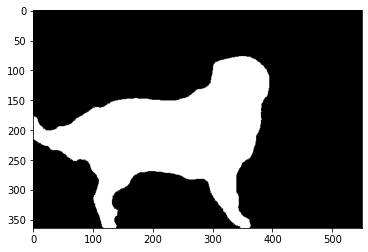

In [28]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

seg_color로만 이루어진 마스크를 만들어 보았다. 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌다. 이제 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.

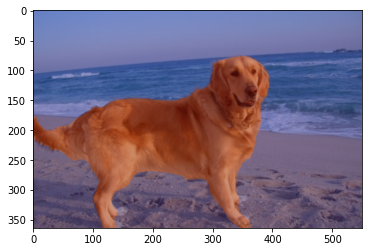

In [29]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것 같다. 결과는 위와 같다.

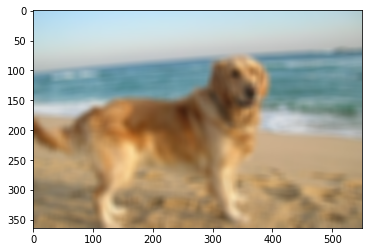

In [30]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만든다. 이때 blur() 함수를 이용한다.

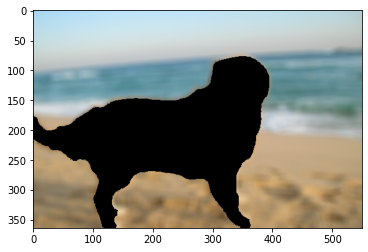

In [31]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠다.

bitwise_not 함수를 이용하면 이미지가 반전된다. 원래 마스크에서는 배경이 0, 강아지가 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 강아지는 0이 된다

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 강아지가 0인 경우에는 강아지가 있던 모든 픽셀이 0이 된다. 결국 강아지가 사라지게 된다.

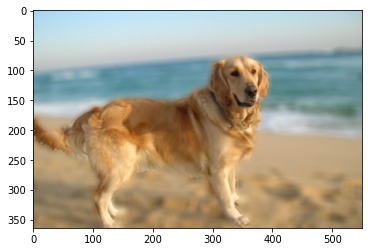

In [32]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경 영상과 강아지 영상을 합쳐보았다. 보시다시피 강아지에 초점이 맞춰진 결과가 나왔다.

※ 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했다.

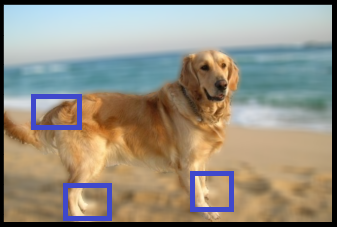

## 사진에서 문제점 찾기

강아지 테두리를 보면 전체적으로 블러처리가 보인다. 또한 모래색과 강아지색이 비슷해 강아지 발을 모래로 처리했다.

현재 이 이미지를 보면 심도가 얕은 편이라 피사체인 강아지가 돋보이긴 하지만 심도를 좀 더 높여야 블러처리도 확실히 하고, 비슷한 색을 가진 모래와 강아지를 확실하게 구별할 수 있다. 심도를 계산하는 모델을 이용하여 적절한 심도를 찾아내어 적용한다. struct2Depth 모델을 이용하면 될 것 같다.

배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있다.

배경을 blur하는 인물모드 사진을 2차례 했기 때문에 크로마키 배경 합성에 중점을 두고 진행하겠다.

(364, 546, 3)


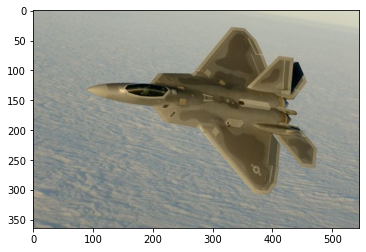

In [33]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
fighter_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/fighter.jpg'  
fighter_img_orig = cv2.imread(fighter_img_path) 

print(fighter_img_orig.shape)
plt.imshow(cv2.cvtColor(fighter_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
segvalues, output = model.segmentAsPascalvoc(fighter_img_path)

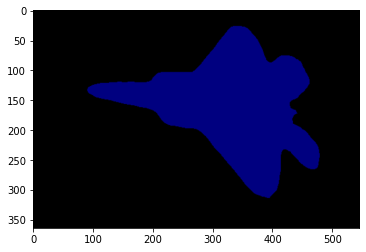

In [35]:
plt.imshow(output)
plt.show()

In [36]:
segvalues

{'class_ids': array([0, 1]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [37]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
aeroplane


In [38]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [39]:
colormap[1]

array([128,   0,   0])

In [40]:
seg_color = (0,0,128)

(364, 546)


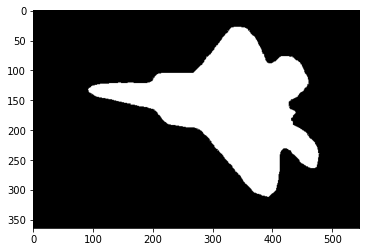

In [41]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

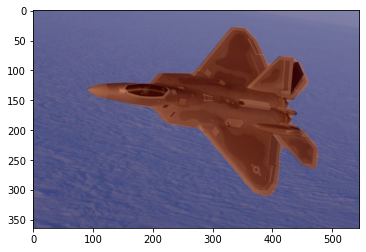

In [42]:
img_show = fighter_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

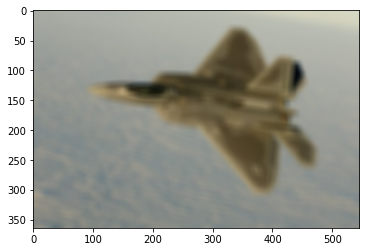

In [43]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
fighter_img_orig_blur = cv2.blur(fighter_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(fighter_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

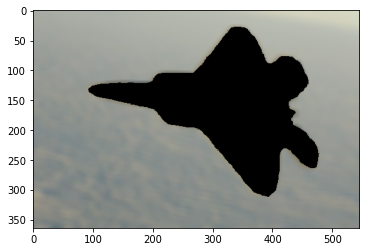

In [44]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(fighter_img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

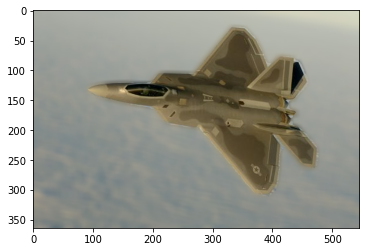

In [45]:
img_concat = np.where(img_mask_color==255, fighter_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(366, 550, 3)


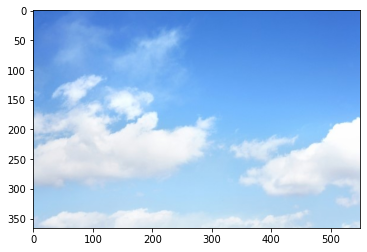

In [46]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
sky_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky.jpg'  
sky_img_orig = cv2.imread(sky_img_path) 

print(sky_img_orig.shape)
plt.imshow(cv2.cvtColor(sky_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

크로마키 배경 합성을 위한 하늘 이미지를 읽는다.

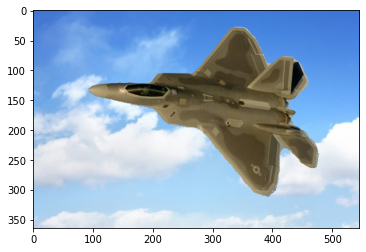

In [47]:
sky_img_orig = cv2.resize(sky_img_orig, (546, 364))
img_concat = np.where(img_mask_color==255, fighter_img_orig, sky_img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

전투기 이미지와 하늘 이미지의 사이즈가 다르기 때문에 서로 사이즈를 맞추어 주고, 크로마키 배경 합성을 시도하였다. 보시다시피 전투기가 다른 하늘에서 기동하는 것을 볼 수 있다.

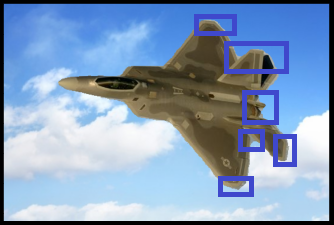

## 사진에서 문제점 찾기

전투기 테두리를 보면 전체적으로 블러처리가 보인다. 문제 해결 방법은 배경을 blur하는 인물모드 사진에서 언급하였다.

EXPLORATION 7 회고

●이번 프로젝트에서 어려웠던 점

카메라 스티커 앱 만들기를 해보았기 때문에 이번 프로젝트는 크게 어렵지 않았다. 오히려 반가웠다. 문제는 시맨틱 세그멘테이션(semantic segmentation)의 한계를 극복하는 솔루션을 완벽하게 알아내기가 힘들었다는 것이다.

●프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

쥬피터 노트북에 URL 넣는법, 이미지 넣는법을 프로젝트 수행을 위해 알아냈고, 능숙하게 사용할 수 있게 됐다.  

시맨틱 세그멘테이션(semantic segmentation)에서 나오는 문제점들을 내가 생각해낸 이론으로 해결할 수 있을 것이라고 추측만 했을 뿐, 실제로 그렇게 해결이 되는지 궁금하다.

●루브릭 평가 지표를 맞추기 위해 시도한 것들

크로마키 배경 합성시, 사이즈 조절을 위한 방법을 찾는데 시간을 약간 할애했다.

결과물에서 문제점을 찾았지만, 어떤 솔루션이 필요한지 바로 알지 못해 여러 이론들을 읽어보았다. 피사계심도 개념을 알고서야 나만의 솔루션을 찾아냈다.

●자기 다짐

카메라 앱이 간단하게 만들어지는 것이 아니라는 것을 이번 프로젝트를 통해 알아간다. 수시로 튀어나오는 문제점들을 해결할 수 있어야 하는데 이론들이 만만치 않다. 나중에 다시 이론들을 읽어보면서 더 나은 솔루션을 찾아내야 한다. 